In [4]:
from brian2 import *
import matplotlib.pyplot as plt
import networkx as nx

# C.elegans Connectome: Homogeneous Control with Leaky Integrate & Fire

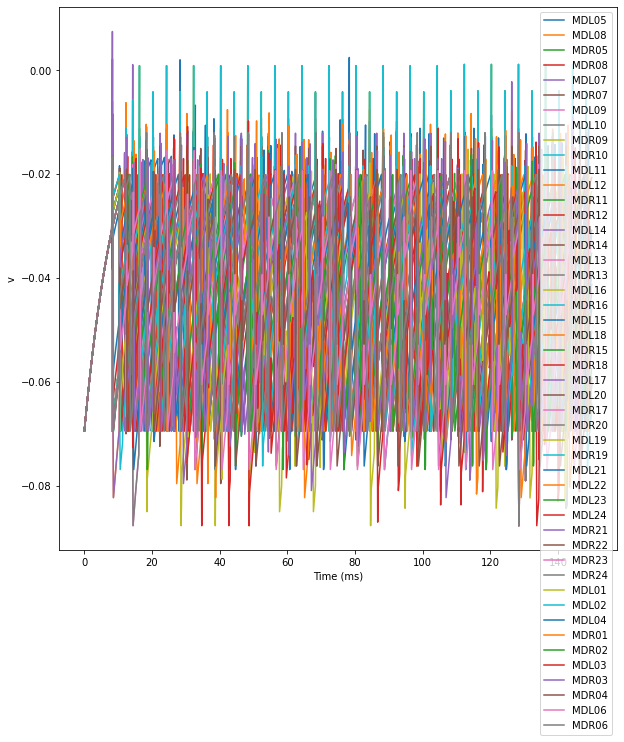

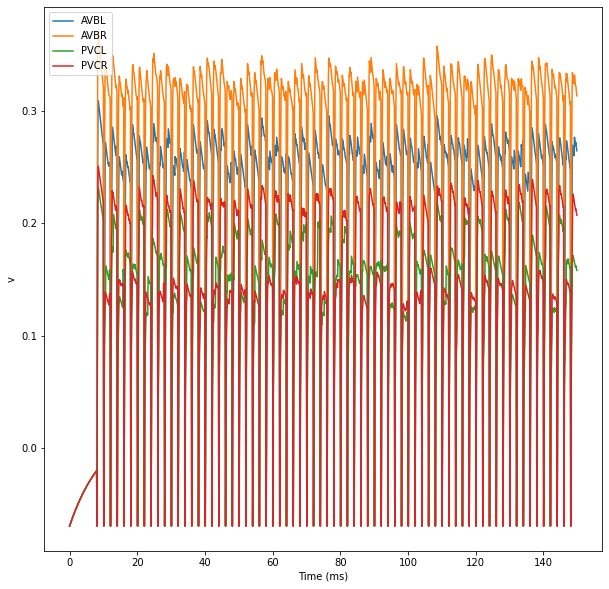

Text(0, 0.5, 'Neuron Index')

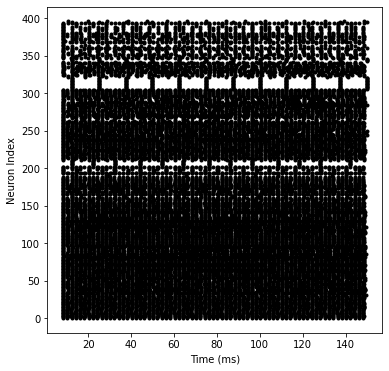

In [5]:
## Control Connectome: Recreating Case Study 1.A.1
# Every brian2 simulation is initiated by "start_scope"
start_scope()

# load connectome via networkx
celegans = nx.read_graphml('c_elegans_control.graphml')

# First create a dictionary that maps each neuron name in the c.elegans connectome to an integer number.
# This is necessary because brian2 defines its neurons as integers

mapping = {}
inverse_mapping={}

for number, name in enumerate(list(celegans.nodes)):
    mapping[name]=number 
    inverse_mapping[number]=name

# Determine how many neurons are in the connectome    
num_neurons = len(mapping.keys()) 

# ====================================================================================


# Define all of the LIAF variables
    ## All units must be explicitly given

tau_m = 10*ms  # membrane time constant (RC)

v_th = -20*mV # threshold potential

# Define the LIAF equations and variables

eqs = '''
dv/dt = -(v-I/g)/tau_m : volt
I : amp
g : siemens'''

# ====================================================================================

# Define a group of LIAF neurons follwoing the equations above.

group = NeuronGroup(num_neurons, model = eqs, threshold = 'v > v_th', reset = 'v=-69.5*mV',
                  refractory = '2*ms',method = 'exact') 

# Provide initial conditions for neurons' voltage and current

group.v = -69.5*mV # resting membrane potential

group.I = '5.0*nA / num_neurons'

group.g = 1*usiemens # Conductance
    
# Select the neurons to be stimulated

stim_list = ['AVBL','AVBR','PVCL','PVCR']

# Use the mapping_dictionary to determine the integer name of the above neurons to be stimulated

group.I[[mapping['AVBL'],mapping['AVBR'],mapping['PVCL'], mapping['PVCR']]] = 20*nA # Constant Input current

# ====================================================================================

# Now, we need to connect the neurons in the NeuronGroup with synapses to reflect the actual connectivity of 
# the C.elegans neurons.

synapses = Synapses(group, model = 'w:1', on_pre = 'v_post+=w*100*mV')

# Let's find the max weight in the celegans connectome to normalize all of the weights between 0 and 1.
weights=[]
for pre, post, weight in celegans.edges.data('weight', default = 1):
    weights.append(int(weight))
max_weight = max(weights)

for (u, v, c) in celegans.edges.data('weight', default=1):
    synapses.connect(i=mapping[u],j=mapping[v])
    # we must also update the weights, c, of each synapse. We will use normalized weights
    synapses.w[mapping[u],mapping[v]] = int(c)/max_weight

# =====================================================================================
# Define two state monitors that will trace voltage and current over time and current for each neuron.

monitor_v = StateMonitor(group, 'v', record=True)
monitor_I = StateMonitor(group, 'I', record=True)

# Define a spike monitor that will record how many times the neurons spike during the simulation
spike_mon = SpikeMonitor(group)

# Define Simulation duration

sim_dur = 150*ms

# Run simulation 

run(sim_dur)

# ======================================================================================
# create list of dorsal muscle neurons
dorsal_muscle_nodes = []

for dorsal_muscles in celegans.nodes():
    if dorsal_muscles.startswith('MD'):
        dorsal_muscle_nodes.append(dorsal_muscles)
        
# Now, find the corresponding integer of each dorsal muscle neuron.

dorsal_muscle_nodes_integers = [mapping[neuron] for neuron in dorsal_muscle_nodes]

# and each stimulated neuron

stimulated_interneurons_integers = [mapping['AVBL'],mapping['AVBR'],mapping['PVCL'], mapping['PVCR']]

# visualize spike trains of dorsal muscle neurons and (stimulated) command interneurons

dorsal_muscle_neurons = plt.figure(figsize=(10,10))
for i in dorsal_muscle_nodes_integers:
    plot(monitor_v.t/ms, monitor_v.v[i])
    xlabel('Time (ms)')
    ylabel('v')
legend([inverse_mapping[i] for i in dorsal_muscle_nodes_integers])
    
plt.show()

interneurons = plt.figure(figsize=(10,10))

for i in stimulated_interneurons_integers:
    plot(monitor_v.t/ms, monitor_v.v[i])
    xlabel('Time (ms)')
    ylabel('v')
legend([inverse_mapping[i] for i in stimulated_interneurons_integers])
    
plt.show()

# ====================================================================================
# generate raster plot

raster_plot = plt.figure(figsize=(6,6))
plot(spike_mon.t/ms, spike_mon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron Index')

In [6]:
# To obtain the total number of spikes for each neuron, you would need to access the Spike Monitor's
# "count" attribute. Since brian2's neuron nomenclature deindividualizes each neuron's original name,
# and assigns it as an integer, it is up to the user to create a dictionary that will map the integer
# name to the user-given name, and then link each spike count to the appropriate neuron.
print(spike_mon.count)

<spikemonitor.count: array([71, 71, 58, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71,
       71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 42, 71, 71,
       65, 71, 71, 54, 62, 63, 71, 71, 71, 71, 71, 71, 66, 71, 71, 71, 24,
       46, 71, 64, 47, 71, 71, 71, 71, 71, 71, 59, 71, 68, 66, 71, 71, 71,
       71, 71, 71, 70, 71, 71, 71, 71, 71, 71, 71, 71, 58, 62, 71, 47, 63,
       55, 71, 71, 36, 47, 71, 47, 71, 44, 37, 71, 63, 71, 71, 71, 71, 71,
       71, 71, 71, 71, 71, 71, 71, 65, 71, 71, 71, 71, 53, 34, 71, 71, 71,
       71, 71, 65, 61, 68, 71, 71, 71, 71, 71, 71, 71, 71, 48, 36, 66, 71,
       71, 33, 31, 71, 36, 69, 71, 71, 71, 71, 71, 47, 36, 61, 71, 71, 71,
       61, 71, 71, 15, 15, 71, 71, 71, 12, 36, 12, 36, 71, 71, 43, 71, 31,
       57, 29, 57, 71, 71, 53, 71, 49, 71, 53, 71, 35, 35, 71, 71, 71, 35,
       35, 71,  9,  8,  9,  8, 71, 71, 24, 24, 24, 24, 36, 36, 36, 71,  0,
       13, 13, 13, 13, 13, 13, 13, 36, 31, 71, 33, 71, 71, 36, 71, 71, 36,
    

# Brian2: LIAF Homogeneous Brain- Perturbed (Re-creating case study 1.A.1)

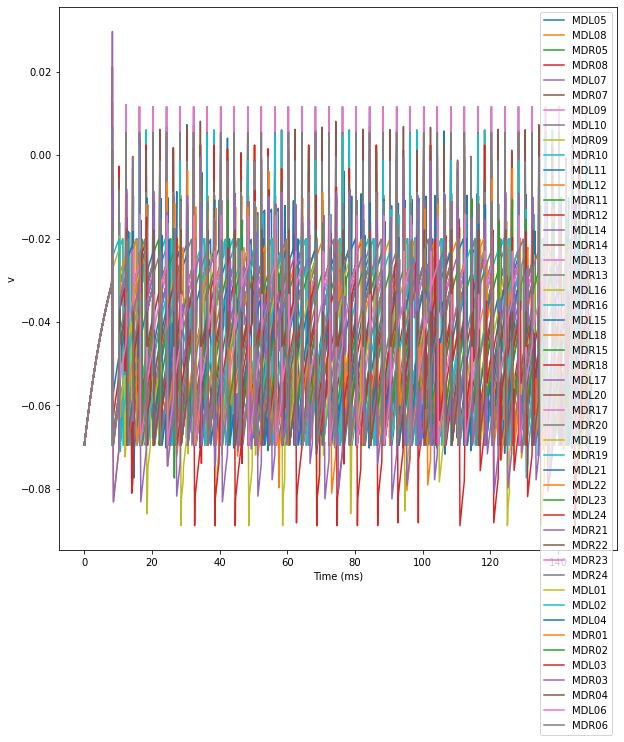

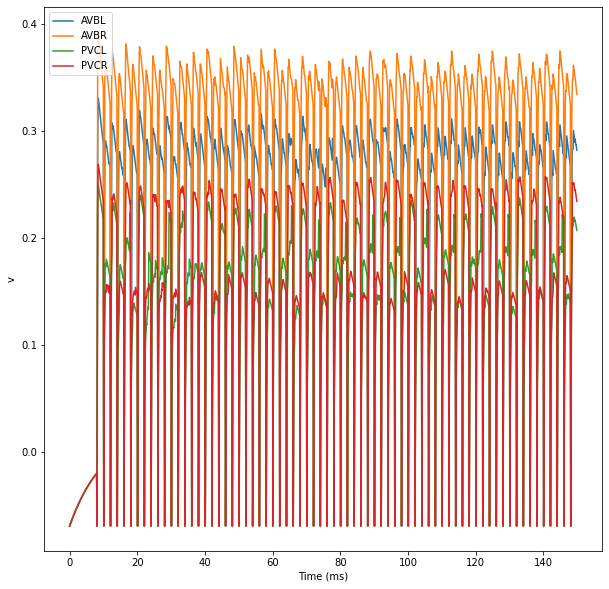

Text(0, 0.5, 'Neuron Index')

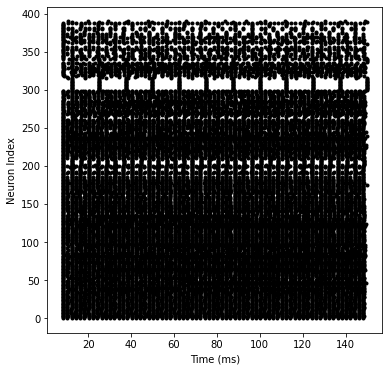

In [7]:
## PERTURBED 
# Every brian2 simulation is initiated by "start_scope"
start_scope()

# load connectome via networkx
celegans = nx.read_graphml('c_elegans_control.graphml')

# Find the dd neurons to ablate and compile them into a list.
dd_neurons=[]
for neuron in list(celegans.nodes):
    if neuron.startswith('DD'):
        dd_neurons.append(neuron)

# Remove the dd neurons from the connectome.
celegans.remove_nodes_from(dd_neurons)

# First create a dictionary that maps each neuron name in the c.elegans connectome to an integer number.
# This is necessary because brian2 defines its neurons as integers

mapping = {}
inverse_mapping={}

for number, name in enumerate(list(celegans.nodes)):
    mapping[name]=number 
    inverse_mapping[number]=name

# Determine how many neurons are in the connectome    
num_neurons = len(mapping.keys()) 

# ====================================================================================


# Define all of the LIAF variables
    ## All units must be explicitly given

tau_m = 10*ms  # membrane time constant (RC)

v_th = -20*mV # threshold potential

# Define the LIAF equations and variables

eqs = '''
dv/dt = -(v-I/g)/tau_m : volt
I : amp
g : siemens'''

# ====================================================================================

# Define a group of LIAF neurons follwoing the equations above.

group = NeuronGroup(num_neurons, model = eqs, threshold = 'v > v_th', reset = 'v=-69.5*mV',
                  refractory = '2*ms',method = 'exact') 

# Provide initial conditions for neurons' voltage and current

group.v = -69.5*mV # resting membrane potential

group.I = '5.0*nA / num_neurons'

group.g = 1*usiemens # Conductance
    
# Select the neurons to be stimulated

stim_list = ['AVBL','AVBR','PVCL','PVCR']

# Use the mapping_dictionary to determine the integer name of the above neurons to be stimulated

group.I[[mapping['AVBL'],mapping['AVBR'],mapping['PVCL'], mapping['PVCR']]] = 20*nA # Constant Input current

# ====================================================================================

# Now, we need to connect the neurons in the NeuronGroup with synapses to reflect the actual connectivity of 
# the C.elegans neurons.

synapses = Synapses(group, model = 'w:1', on_pre = 'v_post+=w*100*mV')

# Let's find the max weight in the celegans connectome to normalize all of the weights between 0 and 1.
weights=[]
for pre, post, weight in celegans.edges.data('weight', default = 1):
    weights.append(int(weight))
max_weight = max(weights)

for (u, v, c) in celegans.edges.data('weight', default=1):
    synapses.connect(i=mapping[u],j=mapping[v])
    # we must also update the weights, c, of each synapse. We will use normalized weights
    synapses.w[mapping[u],mapping[v]] = int(c)/max_weight

# =====================================================================================
# Define two state monitors that will trace voltage and current over time and current for each neuron.

monitor_v = StateMonitor(group, 'v', record=True)
monitor_I = StateMonitor(group, 'I', record=True)

# Define a spike monitor that will record how many times the neurons spike during the simulation
spike_mon = SpikeMonitor(group)

# Define Simulation duration

sim_dur = 150*ms

# Run simulation 

run(sim_dur)

# ======================================================================================
# create list of dorsal muscle neurons
dorsal_muscle_nodes = []

for dorsal_muscles in celegans.nodes():
    if dorsal_muscles.startswith('MD'):
        dorsal_muscle_nodes.append(dorsal_muscles)
        
# Now, find the corresponding integer of each dorsal muscle neuron.

dorsal_muscle_nodes_integers = [mapping[neuron] for neuron in dorsal_muscle_nodes]

# and each stimulated neuron

stimulated_interneurons_integers = [mapping['AVBL'],mapping['AVBR'],mapping['PVCL'], mapping['PVCR']]

# visualize spike trains of dorsal muscle neurons and (stimulated) command interneurons

dorsal_muscle_neurons = plt.figure(figsize=(10,10))
for i in dorsal_muscle_nodes_integers:
    plot(monitor_v.t/ms, monitor_v.v[i])
    xlabel('Time (ms)')
    ylabel('v')
legend([inverse_mapping[i] for i in dorsal_muscle_nodes_integers])
    
plt.show()

interneurons = plt.figure(figsize=(10,10))

for i in stimulated_interneurons_integers:
    plot(monitor_v.t/ms, monitor_v.v[i])
    xlabel('Time (ms)')
    ylabel('v')
legend([inverse_mapping[i] for i in stimulated_interneurons_integers])
    
plt.show()

# ====================================================================================
# generate raster plot

raster_plot = plt.figure(figsize=(6,6))
plot(spike_mon.t/ms, spike_mon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron Index')